In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit


In [2]:
# random seed
np.random.seed(114514)

## Fitting results

In [7]:
'''
30%
d = 64.6432 +- 3.3425
sigma_k = 0.6726% +- 0.1121%
kappa = 3.7827 +- 0.6305
alpha = 0.7027 +- 0.1171
f_AOT = 24.1135% +- 3.6500%


40%
d = 48.9493 +- 2.0980
sigma_k = 0.7797% +- 0.1299%
kappa = 2.6546 +- 0.4424
alpha = 0.4926 +- 0.0821
f_AOT = 31.1141% +- 2.9012%


50%
d = 38.9151 +- 1.7524
sigma_k = 0.2560% +- 0.0427%
kappa = 1.6590 +- 0.2765
alpha = 0.2992 +- 0.0499
f_AOT = 38.2404% +- 1.9021%
'''
wt_list = [30,40,50]
d_list = [64.6432,48.9493,38.9151]
sigma_k_list = [0.6726e-2, 0.7797e-2, 0.2560e-2]
kappa_list = [3.7827, 2.6546, 1.6590]
alpha_list = [0.7027, 0.4926, 0.2992]

## Define function: Orientation correlation


In [3]:
from Vortex import *

In [4]:
## Generate random wave
def gen_vertex_lines(r_grid, sigma_k, kappa, alpha, d, box_size, x_scale=1, n_grid_scale=128):
    #### Wave vector distribution ####
    scale = box_size/d/2 # how many layers in the box
    k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
    # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
    k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
    k_cov  = np.diagflat(k_var)

    ### generate randomwave
    rho = sample_wave_MO_complex(r_grid,k_mean_z,k_cov,n_wave = 100, kappa=kappa)

    scale_zoom = n_grid_scale/rho.shape[0]

    rho, r_grid = scale_rho(rho, r_grid, scale_zoom)

    rho_real = rho.real
    rho_imag = rho.imag
    rho_phase = np.angle(rho)

    vortex_volume = vortex_phase(rho_phase)

    ### Trace defect lines
    array = vortex_volume
    positions_tuple_list, positions_list, adjacent_list, adjacent_id_list = get_adjacency(array)
    poslist_arr = np.array(positions_tuple_list)

    sample, sample_adj_list, sample_adj_dict = get_core(positions_tuple_list, adjacent_id_list, 
                                                    cluster_size=3)
    sample_ordered = get_ordered_points(sample, sample_adj_list)

    sample_ordered_sm = []
    tangent_list = []
    for line in sample_ordered:
        if len(line) == 0:
            continue
        if len(line)>5:
            x = np.arange(len(line))
            x_fine = np.arange(len(line)*x_scale)/x_scale
            arr_line = np.array(line)
            ll = len(line)
            spl_list = [splrep(x,arr_line[:,i],w=np.ones(len(line)),s=ll+np.sqrt(ll*2)) for i in range(3)]
            line_sm = np.array([splev(x_fine,spl) for spl in spl_list]).T
            sample_ordered_sm.append(line_sm)

            # get line tangent
            tangent = np.array(get_tangent(line_sm))
            tangent_list.append(tangent)

        # else:
        #     sample_ordered_sm.append(line)
    return r_grid, rho_real, vortex_volume, sample_ordered_sm, tangent_list


In [5]:
def orien_corr(points, tangens, bounds, rr=[], pbc=[0,0,0], be=False, line=False):
    """
    Calculate spatial correlation of line segments
    
    Args:
        points: array
                point coordinates, N by 3 array

        tangents: array
                segment tangents, N by 3 array

        bounds: list
                box bounds

        rr: array
            pair distances

        pbc: list
             periodic boundary condition
    """
    N = points.shape[0]
    print(points.shape)
    max_r = np.max(rr)
    nr = len(rr)
    dr = rr[1]-rr[0]

    d_cell = [(bounds[0][1]-bounds[0][0]),
            (bounds[1][1]-bounds[1][0]),
            (bounds[2][1]-bounds[2][0])]

    V = d_cell[0]*d_cell[1]*d_cell[2]

    #### handling with finite size effect ####
    index_in = np.arange(N)
    N_in = N
    
    if be:
        index_in_0 = (points[:,0]>=bounds[0][0])*(points[:,0]<bounds[0][1])
        index_in_1 = (points[:,1]>=bounds[1][0])*(points[:,1]<bounds[1][1])
        index_in_2 = (points[:,2]>=bounds[2][0])*(points[:,2]<bounds[2][1])
        index_in = index_in_0*index_in_1*index_in_2
        N_in = np.sum(index_in)
        index_in = np.where(index_in)[0] # transform to coordinate of True's

    rho = N_in/V

    #### two-point correlation ####
    index_d_jk = []
    cos_jk = []
    for i in tqdm(index_in):
        r_ik = points - points[i].reshape(1,3)
        for i_3 in range(3):
            r_ik[:,i_3] = r_ik[:,i_3]-np.floor(r_ik[:,i_3]/d_cell[i_3])*d_cell[i_3]*pbc[i_3] # PBC
        d_ik = np.sqrt(np.sum(r_ik**2,axis=1)) # pair distances

        # cosine
        cos_ik = np.dot(tangens,tangens[i])

        d_ik_list = d_ik[d_ik!=0] # pair distances, self exclusive
        cos_ik = cos_ik[d_ik!=0]
        index_d_ik = np.floor(d_ik_list/dr).astype(int)
        index_d_jk.extend(index_d_ik)
        cos_jk.extend(cos_ik)
        
    index_d_jk = np.array(index_d_jk)

    cos_jk = np.array(cos_jk)
    cos_jk = cos_jk[index_d_jk<nr]    
    
    index_d_jk = index_d_jk[index_d_jk<nr]
    
    #### correlation ####
    n_r = np.zeros(int(nr))
    c_r_sum = np.zeros(int(nr))
    c_r = np.zeros(int(nr))
    for index, cos2_pair in tqdm(zip(index_d_jk, cos_jk**2)):
        c_r_sum[index]+=cos2_pair
        n_r[index]+=1
    
    # normalization
    for ir in range(int(nr)):
        c_r[ir] = c_r_sum[ir]/n_r[ir]
    
    c_r = (3*c_r-1)/2
        
    return c_r

In [7]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]
box_size = 500
bounds = [[-150,150], [-150,150], [-150,150]]

## Generate random wave
n_grid = 100
n_grid_scale = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid_in = np.meshgrid(x,y,z) 

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cr_list = []
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    r_grid, rho_real, vortex_volume, sample_ordered_sm, tangent_list = gen_vertex_lines(r_grid_in, sigma_k, kappa, alpha, 
                                                                      d = d, box_size = box_size,
                                                                      x_scale=6, n_grid_scale = 128)
    sample_all = np.vstack(sample_ordered_sm)
    tangent_all = np.vstack(tangent_list)
    points = sample_all/n_grid_scale*box_size-box_size/2

    cr = orien_corr(points, tangent_all, bounds, rr=rr, pbc=[0,0,0], be=True)
    cr_list.append(cr)


(25992, 3)


100%|██████████| 5714/5714 [00:16<00:00, 347.19it/s]
5388108it [00:03, 1518994.79it/s]


(45864, 3)


100%|██████████| 10382/10382 [01:14<00:00, 138.69it/s]
16904078it [00:11, 1515232.26it/s]


(60846, 3)


100%|██████████| 14428/14428 [02:44<00:00, 87.71it/s] 
32102896it [00:26, 1225385.04it/s]


Text(0, 0.5, '$c(r)$')

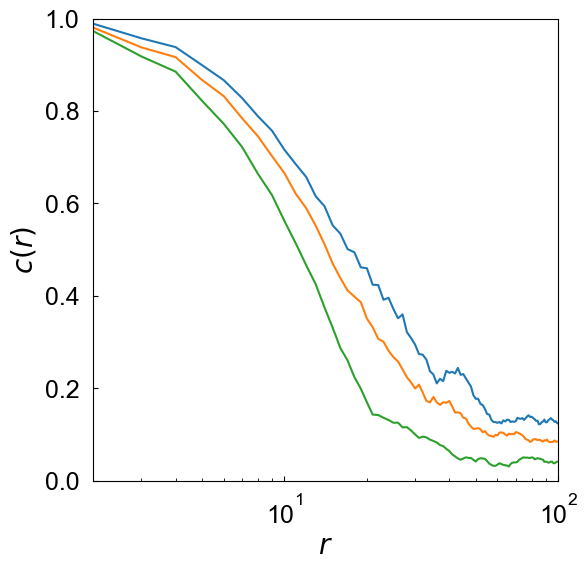

In [12]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    ax.plot(rr, cr_list[i], '-')

ax.set_xlim([2,100])
ax.set_ylim([0,1])
# ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$c(r)$', fontsize=20)

## Define function: Intra-chain OCF


In [46]:
def orien_corr_intra(points, tangents, rr, box_size, n_grid_scale, pbc=[0,0,0]):
    """
    Calculate spatial correlation of line segments
    
    Args:
        points: array
            point coordinates, N by 3 array

        tangents: array
            segment tangents, N by 3 array

        rr: array
            pair distances

        pbc: list
            periodic boundary condition
    """
    n_r = np.zeros(len(rr))
    cos_sum_r = np.zeros(len(rr))
    dr = rr[1]-rr[0]
    max_r = np.max(rr)
    dr_scale = dr/box_size*n_grid_scale
    max_r_scale = max_r/box_size*n_grid_scale
    nr = len(rr)

    for pt, tg in tqdm(zip(points, tangents),total=len(points)):
        # separation along this chain
        da = pt[1:,:] - pt[0:-1,:]
        dl = np.sum(da**2,axis=1)
        n_pt = pt.shape[0]
        
        for i in range(n_pt-1):
            dl_ij = 0
            for j in range(n_pt-1-i):
                dl_ij = dl_ij + dl[i+j]
                if dl_ij > max_r_scale:
                    break
                cos_ij = np.dot(tg[i,:],tg[i+j+1,:])
                index_dl_ij = np.floor(dl_ij/dr_scale).astype(int)
                n_r[index_dl_ij]+=1
                cos_sum_r[index_dl_ij]+=cos_ij

    c_r = cos_sum_r/n_r

    return c_r


        



In [47]:
rr = (np.arange(100)+1)
dr = rr[1]-rr[0]
box_size = 500
## Generate random wave
n_grid = 100
n_grid_scale = 128
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)
r_grid_in = np.meshgrid(x,y,z) 

color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
cr_intra_list = []
for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    r_grid, rho_real, vortex_volume, sample_ordered_list, tangent_list = gen_vertex_lines(r_grid_in, sigma_k, kappa, alpha, 
                                                                      d = d, box_size = box_size,
                                                                      x_scale=4, n_grid_scale = 128)
    
    c_r = orien_corr_intra(sample_ordered_list, tangent_list, rr, box_size, n_grid_scale, pbc=[0,0,0])
    cr_intra_list.append(c_r)


100%|██████████| 566/566 [00:03<00:00, 157.76it/s]


Text(0, 0.5, '$c(r)$')

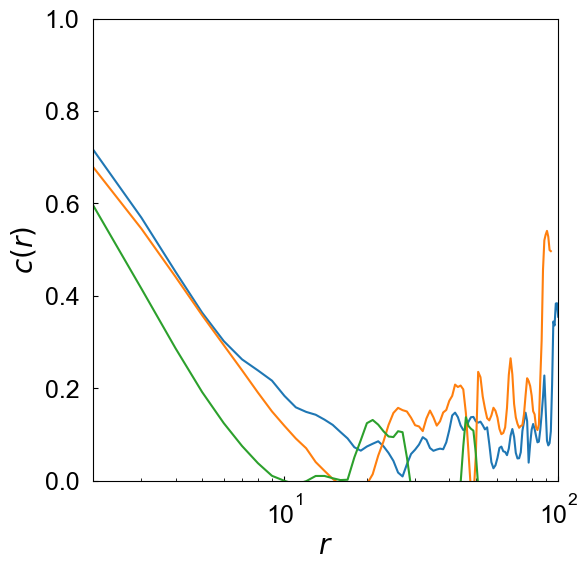

In [ ]:
#### plotting
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i, (sigma_k, kappa, alpha, wt, d) in enumerate(zip(sigma_k_list,kappa_list,alpha_list, wt_list, d_list)):
    # if i>0:
    #     continue
    ax.plot(rr, cr_intra_list[i], '-')

ax.set_xlim([2,100])
ax.set_ylim([0,1])
# ax.set_yscale('log')
ax.set_xscale('log')
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_xlabel(r'$r$', fontsize=20)
ax.set_ylabel(r'$c(r)$', fontsize=20)

(-15.0, 15.0)

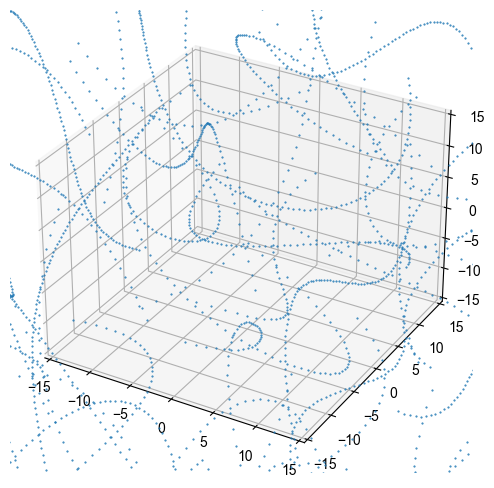

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1,projection='3d')

ax.plot(points[:,0],points[:,1],points[:,2],'.', ms=1)

ax.set_xlim([-15,15])
ax.set_ylim([-15,15])
ax.set_zlim([-15,15])